<a href="https://colab.research.google.com/github/acollin19/comp551/blob/main/A3/assignment3_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow 
import keras
from sklearn.model_selection import train_test_split
import os
import shutil
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## Task 1: Process Data


4422102/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Train: X=(60000, 784), y=(60000,)
Test: X=(10000, 784), y=(10000,)


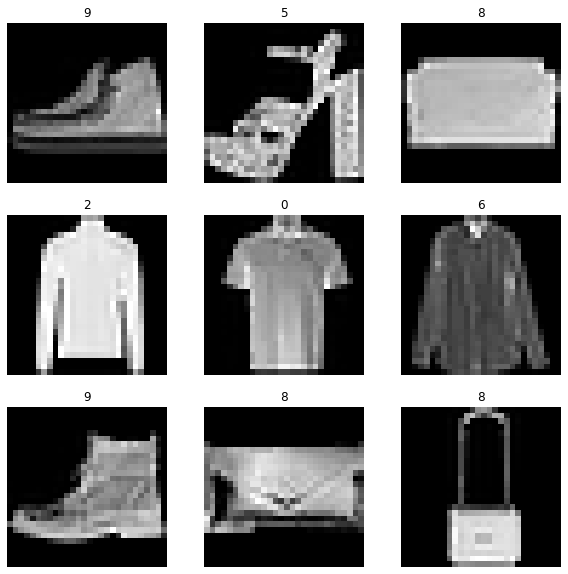

In [4]:
# load dataset
(X_train, y_train_val), (X_test, y_test_val) = fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

# Visualizing the MNIST images
sample_img_idx = np.random.randint(0, X_train.shape[0]+1, 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = X_train[j], y_train_val[j]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

# Reshape and normalize the dataset
X_train = X_train.reshape(X_train.shape[0], 784)
X_train = X_train - np.mean(X_train, axis=0)
X_train = X_train / np.std(X_train, axis=0)

X_test = X_test.reshape(X_test.shape[0], 784)
X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.std(X_test, axis=0)

y_train = np_utils.to_categorical(y_train_val, 10) #10 classes
y_train = y_train == 1

y_test = np_utils.to_categorical(y_test_val, 10)
y_test = y_test == 1
print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

## Task 2: Multilayered Perceptron (MLP) Class

In [3]:
from typing import List

class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size) / 10
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
        
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

In [4]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

In [5]:
from tqdm import tqdm
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps, batch_size, title):
    losses = []
    for _ in tqdm(range(steps)):
        indices = np.random.choice(data_x.shape[0], batch_size)
        batch_x = data_x[indices]
        batch_y = data_y[indices]
        predictions = mlp.forward(batch_x)
        loss = -(batch_y * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)
        mlp.backward(batch_y)
        optimizer.step()
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")

def plot_decision_boundary(mlp: MLP, data_x, data_y, batch_size):
    indices = np.random.choice(data_x.shape[0], batch_size)
    batch_x = data_x[indices]
    batch_y = data_y[indices]
    x0v = np.linspace(np.min(batch_x[:,0]), np.max(batch_x[:,0]), 200)
    x1v = np.linspace(np.min(batch_x[:,1]), np.max(batch_x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T
    yh_all = np.argmax(mlp.forward(x_all), axis=-1)
    plt.scatter(batch_x[:,0], batch_x[:,1], c=batch_y, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.title('decision boundary of the MLP')
    plt.show()
    

## Task 3: Experiments 

## Task 3.1.1 MLP with no hidden layers

100%|██████████| 20/20 [00:03<00:00,  6.32it/s]


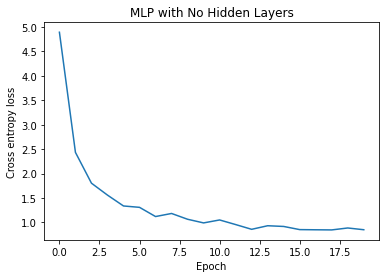

In [6]:
n_features = X_train.shape[-1]
GRADIENT_STEPS = 20

mlp0 = MLP(
    LinearLayer(n_features, 10),
    SoftmaxOutputLayer()
)
opt0 = GradientDescentOptimizer(mlp0, 1e-1)
title = "MLP with No Hidden Layers"
train(mlp0, opt0, X_train, y_train, GRADIENT_STEPS, 1000, title) 

## Task 3.1.2 MLP with one hidden layer

100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


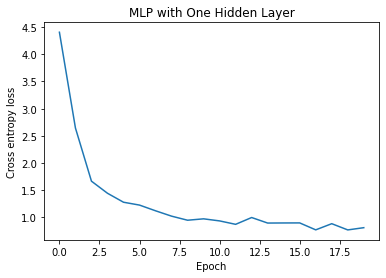

In [7]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
GRADIENT_STEPS = 20

mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-1)
title = "MLP with One Hidden Layer"
train(mlp1, opt1, X_train, y_train, GRADIENT_STEPS, 1000, title) 

## Task 3.1.3 MLP with two hidden layers


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


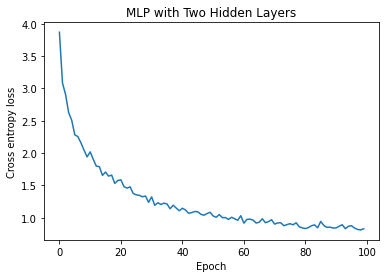

In [8]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, 1e-2)
title = "MLP with Two Hidden Layers"
train(mlp2, opt2, X_train, y_train, 100, 1000, title)

In [9]:
# Test accuracies
acc0 = np.sum(np.argmax(mlp0.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
acc1 = np.sum(np.argmax(mlp1.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
acc2 = np.sum(np.argmax(mlp2.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
print(f'Accuracy of MLP with no hidden layer {acc0}.')
print(f'Accuracy of MLP with one hidden layer {acc1}.')
print(f'Accuracy of MLP with two hidden layer {acc2}.')

Accuracy of MLP with no hidden layer 0.709.
Accuracy of MLP with one hidden layer 0.7256.
Accuracy of MLP with two hidden layer 0.7085.


## Task 3.2 Different Activation Functions


In [10]:
# TanH
class TanHLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        t = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        self.gradient = 1-t**2
        return self.gradient

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

# Leaky-ReLU
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        negslope = 1e-2
        neg = negslope*np.minimum(0, x)
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x) + neg

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


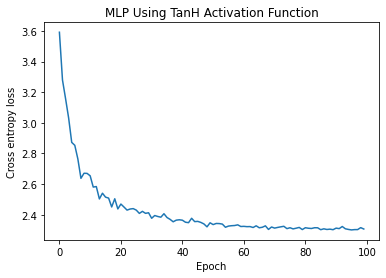

In [11]:
# TanH with 2 hidden layer MLP
tanHmlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
tanHopt2 = GradientDescentOptimizer(tanHmlp2, 1e-2)
title = "MLP Using TanH Activation Function"
train(tanHmlp2, tanHopt2, X_train, y_train, 100, 1000, title)

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


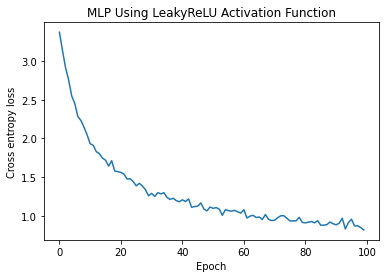

In [12]:
# LeakyReLU with 2 hidden layer MLP
leakyMlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
leakyOpt2 = GradientDescentOptimizer(leakyMlp2, 1e-2)
title = "MLP Using LeakyReLU Activation Function"

train(leakyMlp2, leakyOpt2, X_train, y_train, 100, 1000, title)

In [13]:
# Test accuracies
accTanH = np.sum(np.argmax(tanHmlp2.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
accLeaky = np.sum(np.argmax(leakyMlp2.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
print(f'Accuracy of MLP with TanH activation {accTanH}.')
print(f'Accuracy of MLP with Leaky Relu activation {accLeaky}.')

Accuracy of MLP with TanH activation 0.1046.
Accuracy of MLP with Leaky Relu activation 0.6956.


## Task 3.3 : L2 regularization on two Hidden Layer MLP

In [14]:
# 

## Task 3.4 : Two Hidden Layer MLP Trained with Unnormalized Images

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


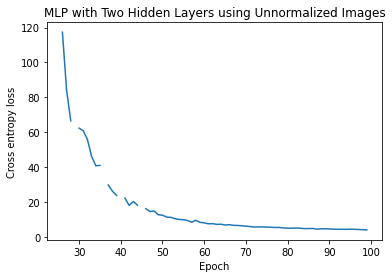

In [15]:
HIDDEN_SIZE = 128

# load dataset
(unnormalized_X_train, unnormalized_y_train), (unnormalized_X_test, unnormalized_y_test) = fashion_mnist.load_data()

unnormalized_X_train = unnormalized_X_train.reshape(unnormalized_X_train.shape[0], 784)
unnormalized_X_test = unnormalized_X_test.reshape(unnormalized_X_test.shape[0], 784)

unnormalized_y_train = np_utils.to_categorical(unnormalized_y_train)
unnormalized_y_test = np_utils.to_categorical(unnormalized_y_test)

unnormalized_mlp = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
unnormalized_opt2 = GradientDescentOptimizer(unnormalized_mlp, 1e-2)
title= "MLP with Two Hidden Layers using Unnormalized Images"
train(unnormalized_mlp, unnormalized_opt2, unnormalized_X_train, unnormalized_y_train, 100, 1000, title)


In [16]:
unnormalized_acc = np.sum(np.argmax(unnormalized_mlp.forward(unnormalized_X_test), axis=1) == unnormalized_y_test) / unnormalized_X_test.shape[0]
print(unnormalized_acc)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


## Task 3.5 : Convolutional Neural Network (ConvNet)

In [5]:
# Reshape the images.
CNN_X_train = X_train.reshape(X_train.shape[0], 28,28,1)
CNN_X_test = X_test.reshape(X_test.shape[0], 28,28,1)


print(X_train.shape) # (60000, 28, 28) #train_images
print(X_test.shape)  # (60000, 28, 28) #train_labels
print(y_train.shape) # (60000,) # train_images
print(y_test.shape) # (60000,) # train_labels


(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [6]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 300
input_shape = (X_train.shape[1:]) # (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down. 
                      # When padding="same" and strides=1, the output has the same size as the input

model = Sequential([
  Conv2D(filters = 4 * num_filters, kernel_size = filter_size, input_shape=(28, 28, 1), padding='same', activation='relu'), 
  MaxPooling2D(pool_size=pool_size), 
  Conv2D(8 * num_filters, kernel_size=(filter_size, filter_size), activation='relu'),  
  MaxPooling2D(pool_size=(pool_size, pool_size)), 
  Dropout(0.25),                        
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 flatten (Flatten)           (None, 2304)              0

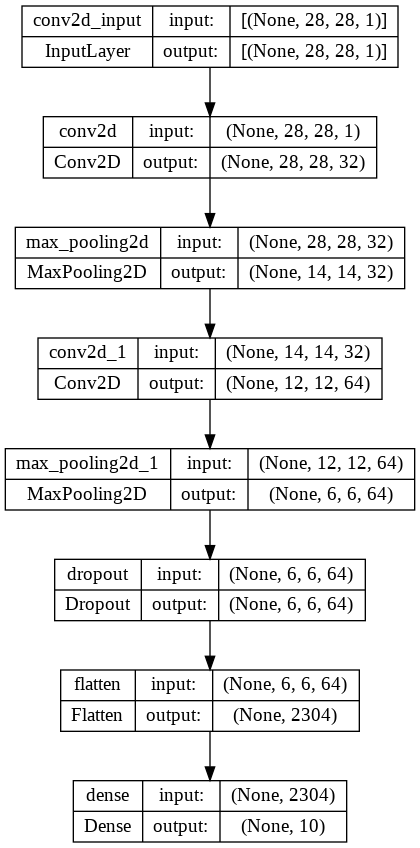

In [7]:
# Summary of the model 
model.summary()
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [8]:
# Compile the model
model.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [11]:
# Train the mdoel
epochs = 20 # switch to GPU to run
# Saving the model during training to be used later
checkpoint = ModelCheckpoint("fashion_mnist_best_model.hdf5",  # saving the best model
                            monitor='val_loss', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)). 
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='auto',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [12]:
# Fitting the model
history = model.fit(
  CNN_X_train,
  y_train, 
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(CNN_X_test, y_test), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings 
)

Epoch 1/20
194/200 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.9043
Epoch 1: val_loss improved from inf to 0.28371, saving model to fashion_mnist_best_model.hdf5
200/200 [==============================] - 2s 9ms/step - loss: 0.2694 - accuracy: 0.9043 - val_loss: 0.2837 - val_accuracy: 0.8988
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9091
Epoch 2: val_loss improved from 0.28371 to 0.27274, saving model to fashion_mnist_best_model.hdf5
200/200 [==============================] - 2s 8ms/step - loss: 0.2531 - accuracy: 0.9091 - val_loss: 0.2727 - val_accuracy: 0.9004
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.9133
Epoch 3: val_loss improved from 0.27274 to 0.26582, saving model to fashion_mnist_best_model.hdf5
200/200 [==============================] - 2s 8ms/step - loss: 0.2408 - accuracy: 0.9133 - val_loss: 0.2658 - val_accuracy: 0.9038
Epoch 4/20
199/200 [=========

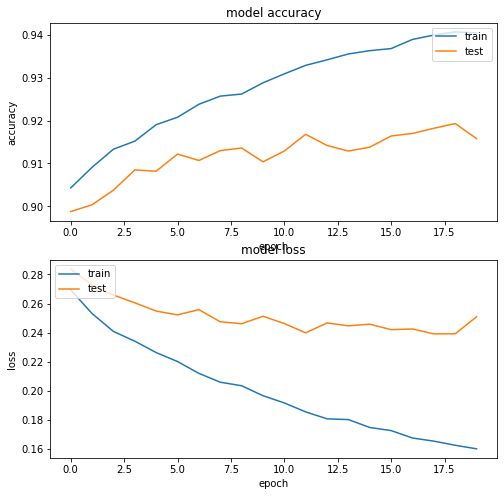

In [13]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

313/313 [==============================] - 1s 3ms/step
Test error: 8.4%


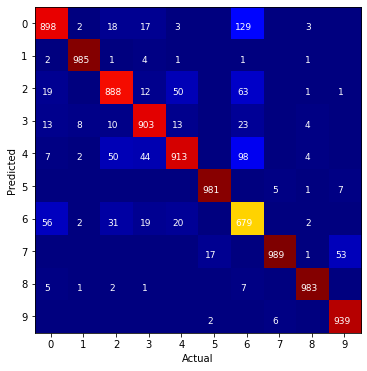

In [16]:
# Model predictions and confusion matrix
test_predictions = np.argmax(model.predict(CNN_X_test),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(y_test,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

## Task 3.6 : MLP Tuning

Attempt 1: Adding more layers

In [17]:
# MLP with three hidden layers
mlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt3 = GradientDescentOptimizer(mlp3, 1e-2)
title = "MLP with Two Hidden Layers"
train(mlp3, opt3, X_train, y_train, 100, 1000, title)

# MLP with four hidden layers
mlp4 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt4 = GradientDescentOptimizer(mlp4, 1e-2)
title = "MLP with Two Hidden Layers"
train(mlp4, opt4, X_train, y_train, 100, 1000, title)

# MLP with five hidden layers
mlp5 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt5 = GradientDescentOptimizer(mlp5, 1e-2)
title = "MLP with Two Hidden Layers"
train(mlp5, opt5, X_train, y_train, 100, 1000, title)

NameError: ignored

In [ ]:
acc3 = np.sum(np.argmax(mlp1.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
acc4 = np.sum(np.argmax(mlp2.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
acc5 = np.sum(np.argmax(mlp2.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]

print(f'Accuracy of MLP with 3, 4, and 5 hidden layers {acc3,acc4,acc5}.')

**Result**: Acheived a higher accuracy than 0 and 2 layer MLP (0.7111, 0.7119) with a 3 layer MLP (0.7194), however not higher than a 1 layer MLP (0.7496).

Attempt 2: Different activation function

When we tested the TanhH and LeakyReLU activation on 2 hidden layer MLP earlier, LeakyReLU increased the accuracy of 2 hidden layer MLP from 0.7119 to 0.7122. 

Additionaly, the top 2 accuracies so far when testing number of hidden layers have been acheived with 1 and 3 hidden layer MLP, we'll test the sigmoid and LeakyReLU activation functions on these two MLPs.

In [ ]:
from numpy.ma.core import expand_dims
# Sigmoid
import math
class SoftPlusLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.log(1 + np.exp(-np.abs(x))) + np.maximum(x,0)
        return self.gradient

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient


# Sigmoid with 1 hidden layer MLP
softplusMlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
softplusOpt1 = GradientDescentOptimizer(softplusMlp1, 1e-2)
title = "MLP Using SoftPlus Activation Function and One Hidden Layer"

train(softplusMlp1, softplusOpt1, X_train, y_train, 100, 1000, title)


# Sigmoid with 3 hidden layer MLP
softplusMlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    SoftPlusLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
softplusOpt3 = GradientDescentOptimizer(softplusMlp3, 1e-2)
title = "MLP Using SoftPlus Activation Function and Three Hidden Layers"

train(softplusMlp3, softplusOpt3, X_train, y_train, 100, 1000, title)

In [ ]:
softplusacc1 = np.sum(np.argmax(softplusMlp1.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
softplusacc3 = np.sum(np.argmax(softplusMlp3.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
print(f'Accuracy of MLP Using Leaky ReLU on 1 and 3 Hidden Layers {softplusacc1,softplusacc3}.')

In [ ]:
# LeakyReLU with 1 hidden layer MLP
leakyMlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
leakyOpt1 = GradientDescentOptimizer(leakyMlp1, 1e-2)
title = "MLP Using LeakyReLU Activation Function and One Hidden Layer"

train(leakyMlp1, leakyOpt1, X_train, y_train, 100, 1000, title)


# LeakyReLU with 3 hidden layer MLP
leakyMlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
leakyOpt3 = GradientDescentOptimizer(leakyMlp3, 1e-2)
title = "MLP Using LeakyReLU Activation Function and Three Hidden Layers"

train(leakyMlp3, leakyOpt3, X_train, y_train, 100, 1000, title)

In [ ]:
leakyacc1 = np.sum(np.argmax(leakyMlp1.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
leakyacc3 = np.sum(np.argmax(leakyMlp3.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]
print(f'Accuracy of MLP Using Leaky ReLU on 1 and 3 Hidden Layers {leakyacc1,leakyacc3}.')

**Result:**  While Leaky ReLU on 1 and 3 hidden layer did not increasr the accuracy, we did obtain a slight increase in accuracy using the SoftPlus activation function on the 1 hidden layer MLP of 0.7592 from 0.7496.